## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import category_encoders as ce

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

from eli5.sklearn import PermutationImportance
from eli5 import show_weights

from scipy.stats import pearsonr

import pickle

## Data Formatting

In [3]:
with open('books_ori.csv', 'r',encoding='utf-8') as f_in, open('temp.txt', 'w',encoding='utf-8') as f_out:
    # 2. Read the CSV file and store in variable
    content = f_in.read()
    print(content.count(','))
    # 3. Write the content into the TXT file
    f_out.write(content)

122412


Here, we need to deal with the fact that the csv file is malformed : the values are comma separated, but one field contains commas on some lines, which causes the lines of the dataframe to be shifted. A quick inspection of the data in excel shows that they are all in the same column, "authors". So, we shall proceed in the following way :

* loop through each line in the original csv as if it were a txt file
* count total comma separated blocks in that line. If it is greater than 12, it means we have extra commas in the author column, and the difference lets us know how many of the next comma seperated values should be grouped together
* once grouped appropriately, grouped blocks get "" added around them so that the csv file can be properly formated
* a new csv is created from this modified file, which is then loaded into the dataframe
* the intermediate text and csv files are removed since they are no longer needed. We have now grouped all our data in a dataframe despite the malformation of the csv file.

In [4]:
file1 = open('books_ori.csv', 'r',encoding='utf-8')
lines = file1.readlines()
modlines=[]
for line in lines:
    line_elements=line.split(',')
    s=''
    for i in range(2):
        s=s+'"'+line_elements[i]+'",'
    t=''
    for i in range(2,3+len(line_elements)-12):
        t=t+line_elements[i]+','
    t=t[:-1]
    s=s+'"'+t+'",'
    for i in range(3+len(line_elements)-12,len(line_elements)):
        s=s+'"'+line_elements[i]+'",'
    s=s.replace('\n','')
    s=s[:-1]
    s=s+'\n'
    modlines.append(s)

file1 = open('out.csv','w',encoding='utf-8')
file1.writelines(modlines)
file1.close()

# os.remove('temp.txt')
# os.remove('out.csv')

## Load Data

In [5]:
df=pd.read_csv('out.csv')

In [6]:
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


In [7]:
df[df['ratings_count'] > 1000000]

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
23,34,The Fellowship of the Ring (The Lord of the Ri...,J.R.R. Tolkien,4.36,0618346252,9780618346257,eng,398,2128944,13670,9/5/2003,Houghton Mifflin Harcourt
284,865,The Alchemist,Paulo Coelho/Alan R. Clarke/Özdemir İnce,3.86,0061122416,9780061122415,eng,197,1631221,55843,5/1/1993,HarperCollins
294,890,Of Mice and Men,John Steinbeck,3.87,0142000671,9780142000670,eng,103,1755253,25554,1/8/2002,Penguin Books
299,930,Memoirs of a Geisha,Arthur Golden,4.11,0739326228,9780739326220,eng,434,1301083,19296,11/15/2005,Random House Large Print Publishing
307,960,Angels & Demons (Robert Langdon #1),Dan Brown,3.89,1416524797,9781416524793,eng,736,2418736,21303,4/1/2006,Pocket Books
310,968,The Da Vinci Code (Robert Langdon #2),Dan Brown,3.84,0307277674,9780307277671,eng,489,1679706,35877,3/28/2006,Anchor
514,1618,The Curious Incident of the Dog in the Night-Time,Mark Haddon,3.88,1400032717,9781400032716,eng,226,1054308,35537,5/18/2004,Vintage


## Data Cleaning

The code below will delete the extra whitespace in the columns that have string data type.

In [8]:
df.rename(columns=lambda x: x.strip(), inplace=True)

## Data Analysis and Preprocessing

### Target Analysis

In [9]:
df.isna().sum()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

There is no "official" missing value in the dataset (column with `NaN` value) but if we look closely in the target column (`average_rating`), there are some rows that have zero value. Intuitivelty, we can think that these books are very bad so reviewers don't hesitate to give 0 score while rating the book

C:\Users\adven\anaconda3\envs\python_bootcamp\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


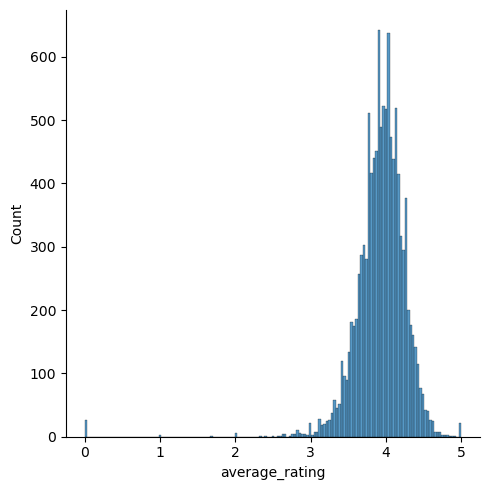

In [10]:
sns.displot(df['average_rating']);

In [11]:
df[df['average_rating'] == 0]

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
265,799,Out to Eat London 2002 (Lonely Planet Out to Eat),Lonely Planet/Mark Honan,0.0,1740592050,9781740592055,eng,295,0,0,9/1/2001,Lonely Planet
375,1302,Juiced Official Strategy Guide,Doug Walsh,0.0,0744005612,9780744005615,eng,112,0,0,6/1/2005,BradyGames
987,3351,Open City 6: The Only Woman He Ever Left,Open City Magazine/James Purdy/Daniel Pinchbec...,0.0,189044717X,9781890447175,eng,200,0,0,10/13/2000,Grove Press Open City Books
2532,9337,How To Meditate: An Anthology Of Talks On Medi...,Frederick P. Lenz,0.0,1932206108,9781932206104,eng,228,0,0,1/1/2004,Frederick P. Lenz Foundation for American Budd...
2533,9338,Insights: Talks On The Nature Of Existence,Frederick P. Lenz,0.0,1932206086,9781932206081,eng,304,0,0,1/1/2003,Frederick P. Lenz Foundation for American Budd...
2758,10200,Venac sonetnih venaca; Puževa srma,Dobrica Erić,0.0,8644101277,9788644101277,srp,222,0,0,1/1/1996,"Izdavačka agencija Draganić"""""
3493,12712,Brodie's notes on Aldous Huxley's brave new world,Graham Handley,0.0,0333581296,9780333581292,eng,71,0,0,8/20/1992,Macmillan
4242,15186,American Film Guide,Frank N. Magill,0.0,0893562505,9780893562502,eng,5,0,0,1/1/1983,Salem Press Inc
4678,16806,The Man and the Author: John Milton: Twentieth...,J. Martin Evans,0.0,0415940478,9780415940474,eng,386,0,0,11/8/2002,Routledge
5325,19257,Canopy: A Work for Voice and Light in Harvard ...,David Ward/Parveen Adams/Seamus Heaney/Ivan ...,0.0,0916724948,9780916724948,eng,63,0,0,12/31/1997,Arts Publications


But, when we examine the content of these data, it seems like those book are not receiving any review from the reviewers. 

**Remark: We *probably* can exclude these data later in the modelling stage**

Next, we can look to the correlation between the numerical features. BookID and isbn are just the identifier of the books so we can neglect those columns.

In [12]:
df[['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count']].corr()

,average_rating,num_pages,ratings_count,text_reviews_count
average_rating,1.000000,0.150809,0.038205,0.033734
num_pages,0.150809,1.000000,0.034353,0.036998
ratings_count,0.038205,0.034353,1.000000,0.865979
text_reviews_count,0.033734,0.036998,0.865979,1.000000


There are weak correlations between the target column `average_rating` to the numerical features such as `num_pages`, `ratings_count`, and `text_review_count`. Some of the remarks are:

* The highest correlation exist between `average_rating` and `num_pages`
* The lowest correlation exsist between `average_rating` and `text_review_counts`
* There is strong correlation between `ratings_count` and `text_review_count` columns. This is a **strong evidence of collinearity** so we can remove one of these column in the modelling stage.

### Textual Feature Analysis

In [13]:
print(len(df['title'].unique())/len(df['title']))

0.9303496000718972


In [14]:
print(len(df['authors'].unique())/len(df['authors']))

0.5970162667385639


In [15]:
print(len(df['language_code'].unique())/len(df['language_code']))

0.0024265300620113237


We see here that title has 93% as many unique values as values, indicating that there is not that much redundance in titles. Authors has 59% as many, indicating some redundance. Since authors are grouped into combinations, it may therefore be worthwile to split them into author1,author2, etc... Languages are unsuprisingly very "un-redundant". Let's plot them here.

In [16]:
print(df['language_code'].unique())

['eng' 'en-US' 'fre' 'spa' 'en-GB' 'mul' 'grc' 'enm' 'en-CA' 'ger' 'jpn'
 'ara' 'nl' 'zho' 'lat' 'por' 'srp' 'ita' 'rus' 'msa' 'glg' 'wel' 'swe'
 'nor' 'tur' 'gla' 'ale']


In [17]:
print(df['language_code'].nunique())

27


We see, here, that english is split up into 4 languages, as `eng`, `en-US`, `en-GB`, `en-CA`, and `eng-CAN`. Perhaps it would be better to consolidate these into eng, since, for all other languages, the language in that field would determine the language in the title.

In [18]:
def language_trim(lang):
    if(lang in ['en-US','en-GB', 'en-CA', 'en-CAN']):
        return 'eng'
    return lang
language_trim=np.vectorize(language_trim)

In [19]:
df['language_code']=language_trim(df['language_code'])

In [20]:
df['language_code'].unique()

array(['eng', 'fre', 'spa', 'mul', 'grc', 'enm', 'ger', 'jpn', 'ara',
       'nl', 'zho', 'lat', 'por', 'srp', 'ita', 'rus', 'msa', 'glg',
       'wel', 'swe', 'nor', 'tur', 'gla', 'ale'], dtype=object)

In [21]:
print(df['language_code'].nunique())

24


This process can reduce the number of categories in `language_code` column from 27 to 24. Since this number is very small compared to the number of rows, we can include this feature to the model by perfoming the categorical encoding method.

### Feature Engineering

We can utilise the datetime feature -- `publication date` -- for creating new feature that describe the age of the book since a certain date. However, before working with the `publication_date`, I noticed the incorrect value in the `publication_date`, that makes the string-to-date conversion error:
* There are some values that present the invalid date such as `11/31/2000` and `6/31/1982`

We need to replace those values with the correct one before moving to the next step

In [22]:
# change the value of the invaluid date, and store the result on the new column
df['publication_date_fixed'] = df['publication_date'].replace({
                                                        '11/31/2000': '12/01/2000',
                                                        '6/31/1982' : '07/01/1982'
                                                        })

# convert the new column to datetime
df['publication_date_fixed'] = pd.to_datetime(df['publication_date_fixed'], format='%m/%d/%Y')

# determine the `reference_date`
df['reference_date'] = pd.to_datetime('12/01/2023', format='%m/%d/%Y')

In [23]:
df[['publication_date', 'publication_date_fixed', 'reference_date']]

,publication_date,publication_date_fixed,reference_date
0,9/16/2006,2006-09-16,2023-12-01
1,9/1/2004,2004-09-01,2023-12-01
2,11/1/2003,2003-11-01,2023-12-01
3,5/1/2004,2004-05-01,2023-12-01
4,9/13/2004,2004-09-13,2023-12-01
...,...,...,...
11122,12/21/2004,2004-12-21,2023-12-01
11123,12/1/1988,1988-12-01,2023-12-01
11124,8/1/1993,1993-08-01,2023-12-01
11125,2/27/2007,2007-02-27,2023-12-01


In this step I created 3 new features:
* `days_from_reference_date`   : days difference between `publication_date` and `reference_date` (1st December 2023)
* `months_from_reference_date` : months difference between `publication_date` and `reference_date` (1st December 2023)
* `years_from_reference_date`  : years difference between `publication_date` and `reference_date` (1st December 2023)

In [24]:
# calculate number of days between `publication_date` to `reference_date`
df['days_from_reference_date'] = (df['reference_date'] - df['publication_date_fixed']).dt.days

# calculate number of months between `publication_date` to `reference_date`
df['months_from_reference_date'] = ((df['reference_date'] - df['publication_date_fixed'])/np.timedelta64(1, 'M'))
df['months_from_reference_date'] = df['months_from_reference_date'].astype(int)

# calculate number of years between `publication_date` to `reference_date`
df['years_from_reference_date'] = ((df['reference_date'] - df['publication_date_fixed'])/np.timedelta64(1, 'Y'))
df['years_from_reference_date'] = df['years_from_reference_date'].astype(int)

In [25]:
df[['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count',
    'days_from_reference_date', 'months_from_reference_date', 'years_from_reference_date'
   ]].corr()

,average_rating,num_pages,ratings_count,text_reviews_count,days_from_reference_date,months_from_reference_date,years_from_reference_date
average_rating,1.000000,0.150809,0.038205,0.033734,0.027945,0.027864,0.029216
num_pages,0.150809,1.000000,0.034353,0.036998,0.018211,0.018244,0.019459
ratings_count,0.038205,0.034353,1.000000,0.865979,-0.043959,-0.043948,-0.044080
text_reviews_count,0.033734,0.036998,0.865979,1.000000,-0.065995,-0.065964,-0.066240
days_from_reference_date,0.027945,0.018211,-0.043959,-0.065995,1.000000,0.999993,0.999390
months_from_reference_date,0.027864,0.018244,-0.043948,-0.065964,0.999993,1.000000,0.999392
years_from_reference_date,0.029216,0.019459,-0.044080,-0.066240,0.999390,0.999392,1.000000


Based on the correlation test, we can see that `years_from_reference_date` feature has the greatest correlation to the target variable among the new features engineered from the `publication_date`, so we might select this feature and neglect 2 others since they highly dependent each other.

### Handling Discrepancies

Next things we want to fix in this stage are some discrepancies I found in the dataset:

* Authors column have multiple names separated by `/`,
* But the second names are not necessarily the author. This can be the reader or someone who given the foreword on the book. Eg: The Known World, Mere Christianity
* Same books can appear in different rows, for example caused by different publishers or publishing date.

So, this is the way I decided to handle this discrepancies:
* Separate the `authors` column into multiple columns e.g. `author1`, `author2`, `author3`, ...
* Concat `title` with `authors1` column
* Aggregating the `num_pages`, `ratings_count`, and `text_review_count` based on the concated column and the preprocessed `language_code`. This will let some rows that recorded identical books be squeezed into unique representation, identified by `bookname_author1` column.

In [26]:
# create dataframe that separate the name of each authors
df_authors = df['authors'].str.split('/', expand=True)

# rename the columns with author1, author2, ...
df_authors.columns = ["author"+ str(i) for i in range(1, df_authors.shape[1] + 1)]

# delete whitespace (if any)
for i in df_authors.columns:
    df_authors[i] = df_authors[i].str.strip()

# create a copy of df
df_copy = df.copy()

# concat df_copy with df_authors
df_author_sep = pd.concat([df_copy, df_authors], axis=1).drop('authors', axis=1)

# remove the rows with 0 average_rating
df_author_sep = df_author_sep[df_author_sep['average_rating'] != 0]

# delete whitespace in title column (if any)
df_author_sep["title"] = df_author_sep["title"].str.strip()

# concat title with author1
df_author_sep['bookname_author1'] = df_author_sep['title'].str.strip() + "_" + df_author_sep["author1"].str.strip()

# aggregate the `num_pages`, `ratings_count`, and `text_review_count` columns based on the 
# `bookname_author1` and `language_code` column
df_title_auth_num = df_author_sep[['bookname_author1', 
                                   'num_pages', 'ratings_count', 
                                   'text_reviews_count', 'language_code', 'average_rating',
                                   'days_from_reference_date', 'months_from_reference_date',
                                   'years_from_reference_date'
                                  ]] \
                        .groupby(['bookname_author1', 'language_code']).mean().reset_index()

In [27]:
df_title_auth_num.shape

(10421, 9)

In [28]:
df_title_auth_num.head()

,bookname_author1,language_code,num_pages,ratings_count,text_reviews_count,average_rating,days_from_reference_date,months_from_reference_date,years_from_reference_date
0,$30 Film School: How to Write Direct Produce...,eng,528.000,30.0,4.00,3.49000,7507.00,246.0,20.000
1,'Salem's Lot_Stephen King,eng,409.125,10731.5,103.25,4.04875,11770.25,386.0,31.875
2,1 000 Places to See Before You Die_Patricia Sc...,eng,992.000,36303.0,439.00,3.85000,7498.00,246.0,20.000
3,10 lb Penalty_Dick Francis,eng,320.000,3490.0,177.00,3.90000,7059.00,231.0,19.000
4,100 Great Fantasy Short Short Stories_Isaac As...,eng,395.000,204.0,19.00,3.91000,14001.00,460.0,38.000


In [29]:
df.shape

(11127, 17)

This method squeeze the data from 11127 to 10421 rows

In [30]:
df_title_auth_num[['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count',
                   'days_from_reference_date', 'months_from_reference_date', 'years_from_reference_date']].corr()

,average_rating,num_pages,ratings_count,text_reviews_count,days_from_reference_date,months_from_reference_date,years_from_reference_date
average_rating,1.000000,0.165774,0.040421,0.030609,0.048209,0.048116,0.049476
num_pages,0.165774,1.000000,0.031158,0.032971,0.017001,0.017018,0.018338
ratings_count,0.040421,0.031158,1.000000,0.871895,-0.048778,-0.048791,-0.048813
text_reviews_count,0.030609,0.032971,0.871895,1.000000,-0.070760,-0.070761,-0.070892
days_from_reference_date,0.048209,0.017001,-0.048778,-0.070760,1.000000,0.999993,0.999388
months_from_reference_date,0.048116,0.017018,-0.048791,-0.070761,0.999993,1.000000,0.999391
years_from_reference_date,0.049476,0.018338,-0.048813,-0.070892,0.999388,0.999391,1.000000


In [31]:
df[['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count',
    'days_from_reference_date', 'months_from_reference_date', 'years_from_reference_date']].corr()

,average_rating,num_pages,ratings_count,text_reviews_count,days_from_reference_date,months_from_reference_date,years_from_reference_date
average_rating,1.000000,0.150809,0.038205,0.033734,0.027945,0.027864,0.029216
num_pages,0.150809,1.000000,0.034353,0.036998,0.018211,0.018244,0.019459
ratings_count,0.038205,0.034353,1.000000,0.865979,-0.043959,-0.043948,-0.044080
text_reviews_count,0.033734,0.036998,0.865979,1.000000,-0.065995,-0.065964,-0.066240
days_from_reference_date,0.027945,0.018211,-0.043959,-0.065995,1.000000,0.999993,0.999390
months_from_reference_date,0.027864,0.018244,-0.043948,-0.065964,0.999993,1.000000,0.999392
years_from_reference_date,0.029216,0.019459,-0.044080,-0.066240,0.999390,0.999392,1.000000


If we measure the target-feature correlation in this new dataset, we can notice slight improvement in the correlation of the target to `num_pages`, `ratings_count`, `days_from_reference_date`, `months_from_reference_date`, and `years_from_reference_date`. However, the correlation to the `text_review_count` is slightly decreasing.

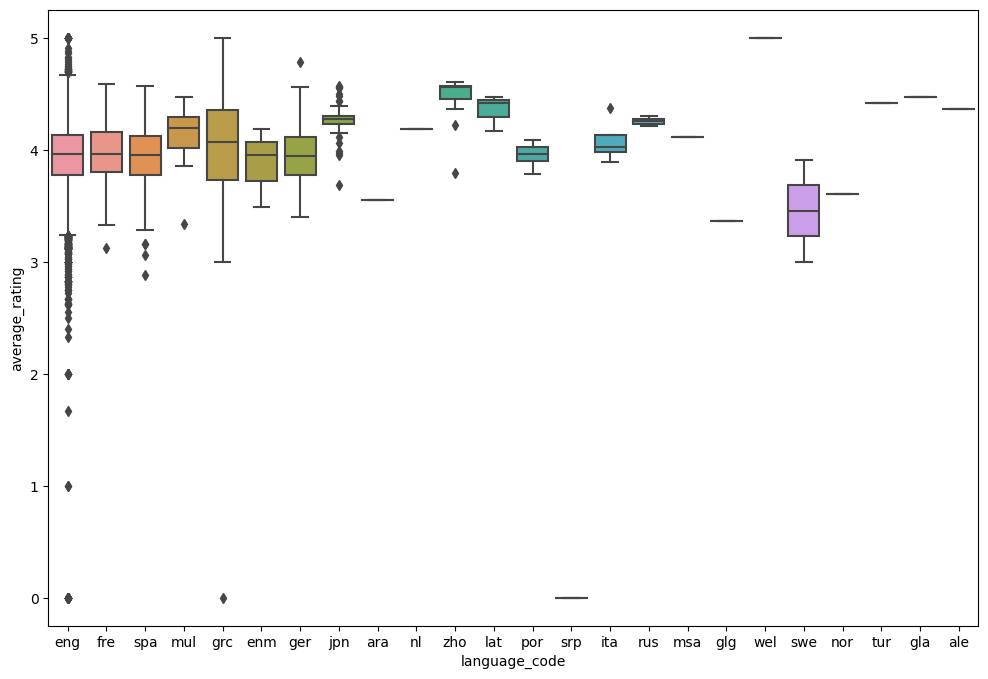

In [32]:
plt.figure(figsize=(12,8))
sns.boxplot(data=df, x='language_code', y='average_rating');

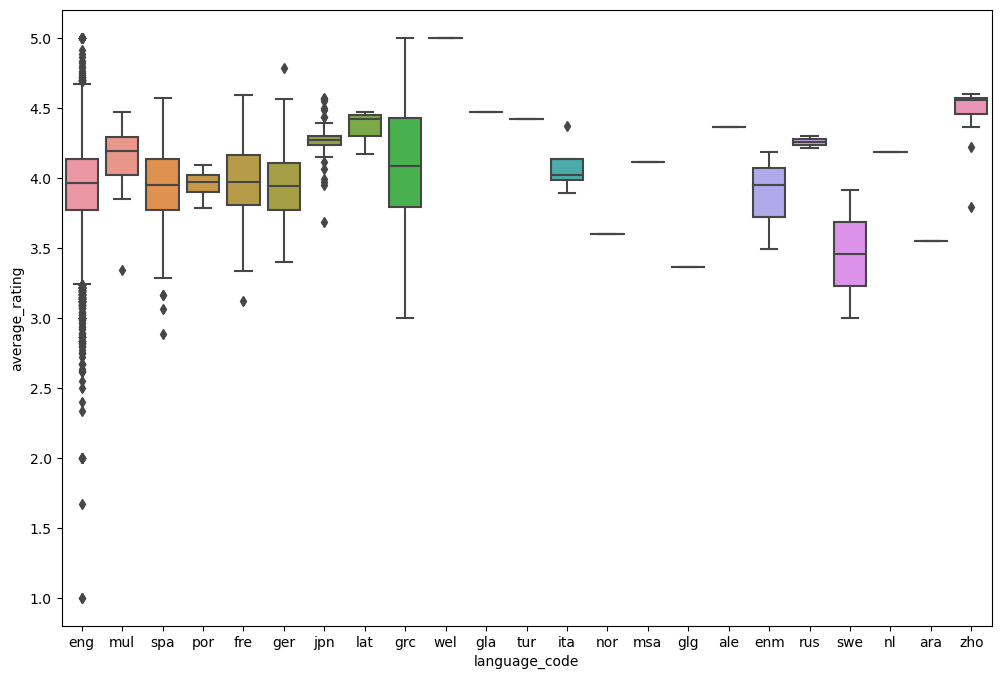

In [33]:
plt.figure(figsize=(12,8))
sns.boxplot(data=df_title_auth_num, x='language_code', y='average_rating');

By plotting the distribution of `average_rating` by `language_code` there is also small change in the distribution.

### Distribution Analysis of Numerical Features

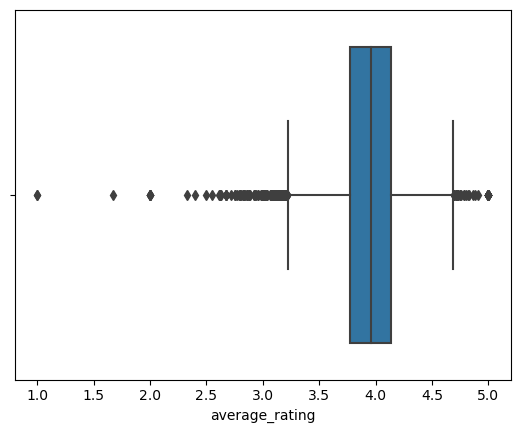

In [34]:
sns.boxplot(data=df_title_auth_num, x='average_rating');

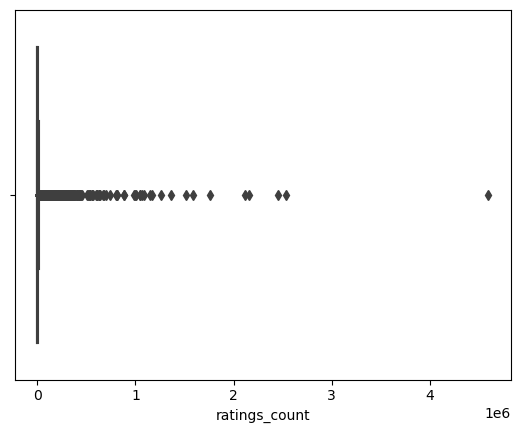

In [35]:
sns.boxplot(data=df_title_auth_num, x='ratings_count');

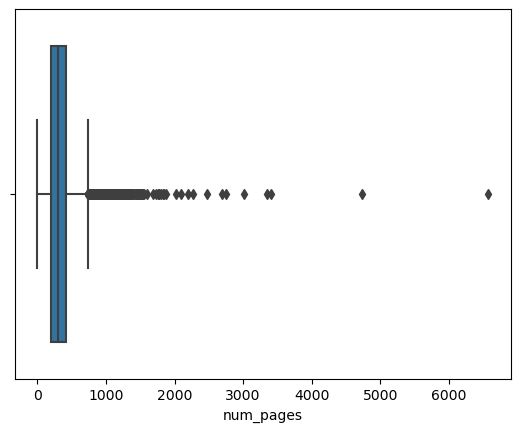

In [36]:
sns.boxplot(data=df_title_auth_num, x='num_pages');

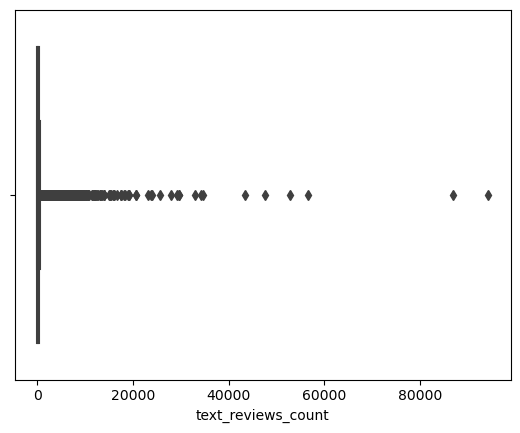

In [37]:
sns.boxplot(data=df_title_auth_num, x='text_reviews_count');

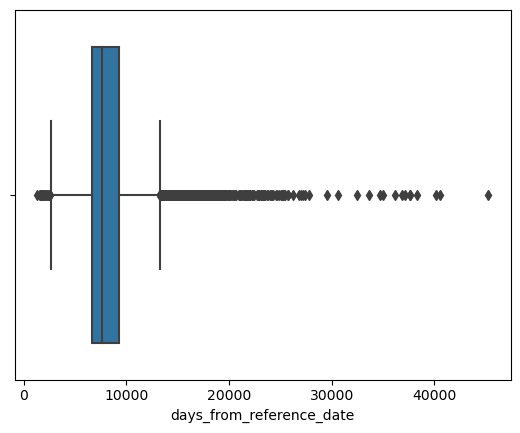

In [38]:
sns.boxplot(data=df_title_auth_num, x='days_from_reference_date');

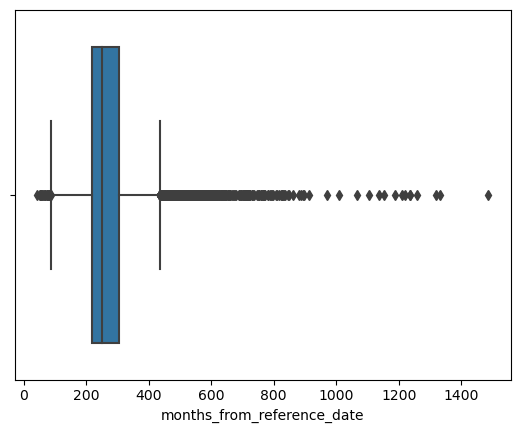

In [39]:
sns.boxplot(data=df_title_auth_num, x='months_from_reference_date');

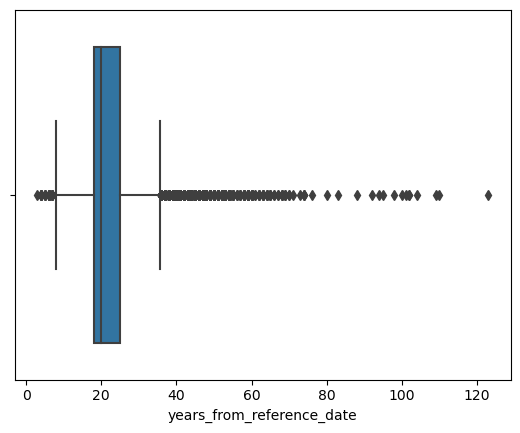

In [40]:
sns.boxplot(data=df_title_auth_num, x='years_from_reference_date');

From the distribution analysis, we found that the distribution of numerical features are strongly skewed. One method to fix the distribution is by doing log transformation. But performing log transformation directly to the numerical data can be resulted in `Inf` value, since `log(0)` is not identified. So, we need to add 1 for each value of the data to handle infinity.

**_Important: To see the real value of the predicted values, we need to inverse the operation in order to return back the real value_**

In [41]:
df_title_auth_num['ratings_count_log'] = np.log(df_title_auth_num['ratings_count']+1)
df_title_auth_num['num_pages_log'] = np.log(df_title_auth_num['num_pages']+1)
df_title_auth_num['text_reviews_count_log'] = np.log(df_title_auth_num['text_reviews_count']+1)
df_title_auth_num['average_rating_log'] = np.log(df_title_auth_num['average_rating']+1)
df_title_auth_num['days_from_reference_date_log'] = np.log(df_title_auth_num['days_from_reference_date']+1)
df_title_auth_num['months_from_reference_date_log'] = np.log(df_title_auth_num['months_from_reference_date']+1)
df_title_auth_num['years_from_reference_date_log'] = np.log(df_title_auth_num['years_from_reference_date']+1)

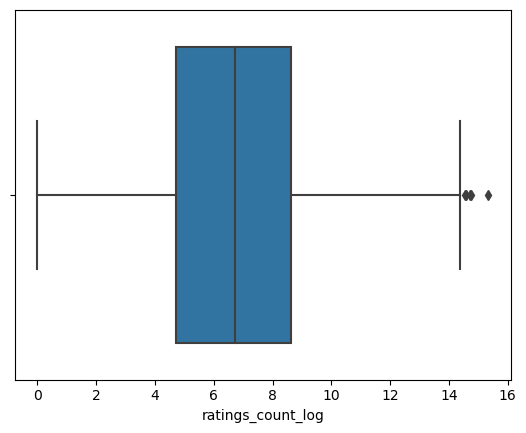

In [42]:
sns.boxplot(data=df_title_auth_num, x='ratings_count_log');

C:\Users\adven\anaconda3\envs\python_bootcamp\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


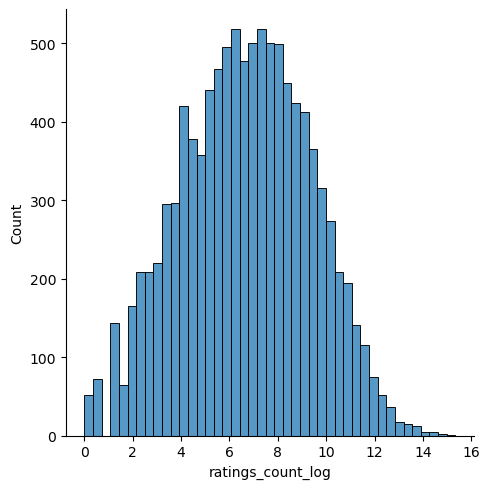

In [43]:
sns.displot(df_title_auth_num['ratings_count_log'])

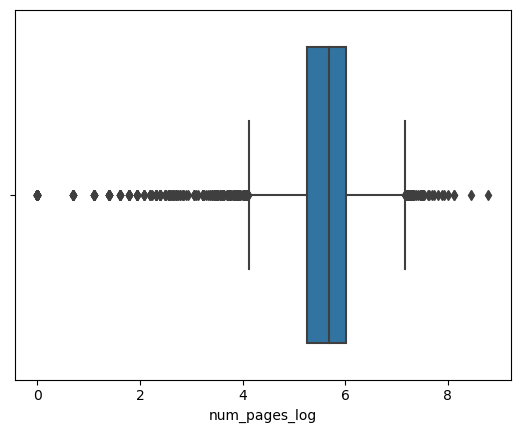

In [44]:
sns.boxplot(data=df_title_auth_num, x='num_pages_log');

C:\Users\adven\anaconda3\envs\python_bootcamp\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


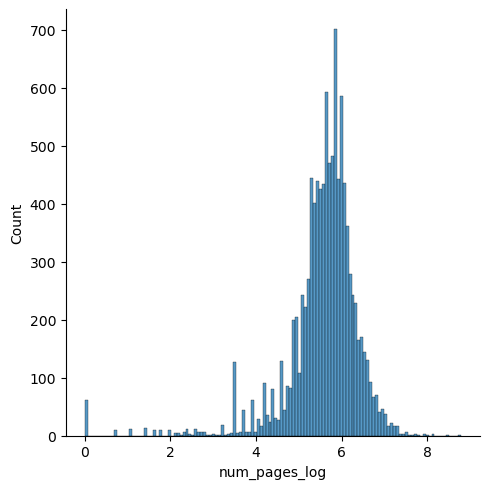

In [45]:
sns.displot(df_title_auth_num['num_pages_log'])

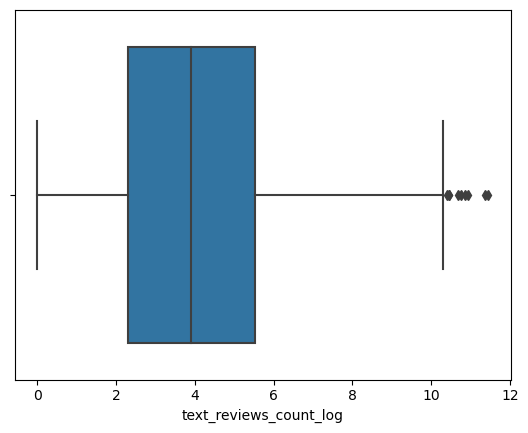

In [46]:
sns.boxplot(data=df_title_auth_num, x='text_reviews_count_log');

C:\Users\adven\anaconda3\envs\python_bootcamp\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


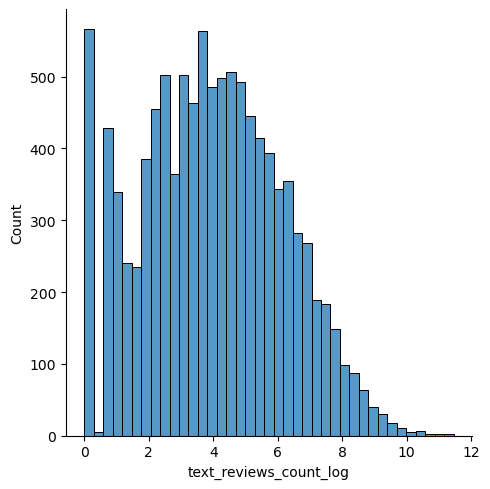

In [47]:
sns.displot(df_title_auth_num['text_reviews_count_log'])

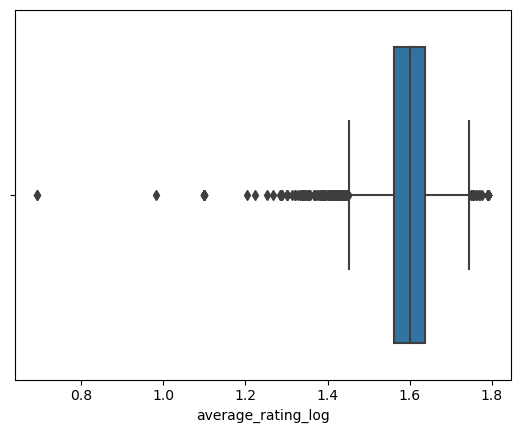

In [48]:
sns.boxplot(data=df_title_auth_num, x='average_rating_log');

C:\Users\adven\anaconda3\envs\python_bootcamp\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


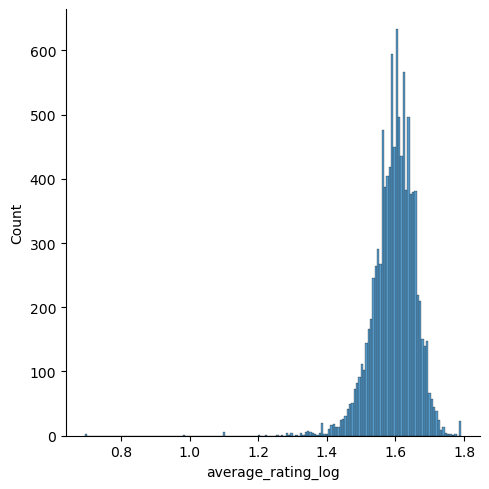

In [49]:
sns.displot(df_title_auth_num['average_rating_log'])

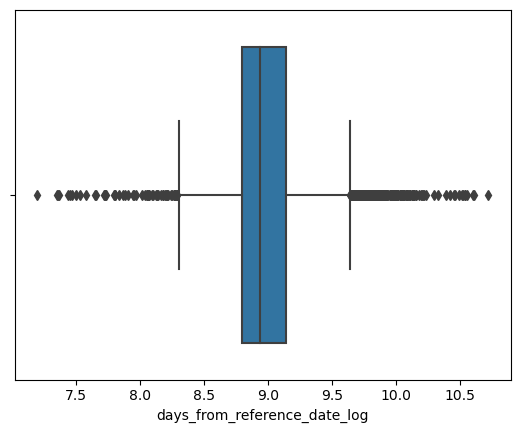

In [50]:
sns.boxplot(data=df_title_auth_num, x='days_from_reference_date_log');

C:\Users\adven\anaconda3\envs\python_bootcamp\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


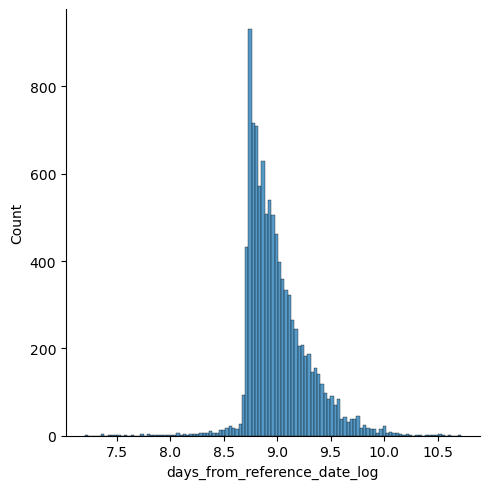

In [51]:
sns.displot(df_title_auth_num['days_from_reference_date_log'])

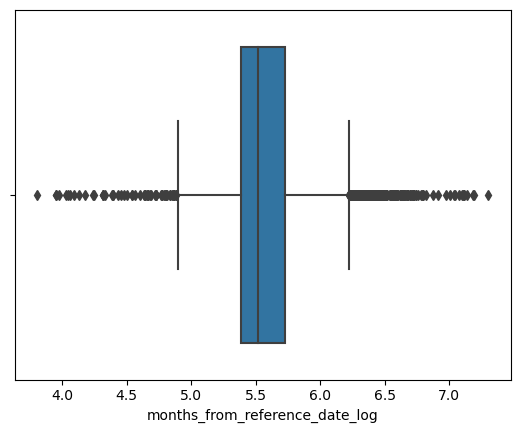

In [52]:
sns.boxplot(data=df_title_auth_num, x='months_from_reference_date_log');

C:\Users\adven\anaconda3\envs\python_bootcamp\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


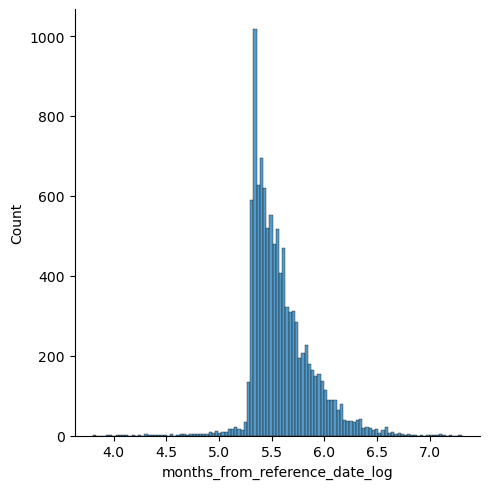

In [53]:
sns.displot(df_title_auth_num['months_from_reference_date_log'])

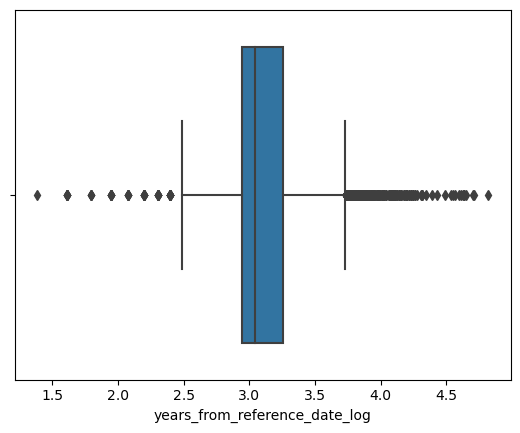

In [54]:
sns.boxplot(data=df_title_auth_num, x='years_from_reference_date_log');

C:\Users\adven\anaconda3\envs\python_bootcamp\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


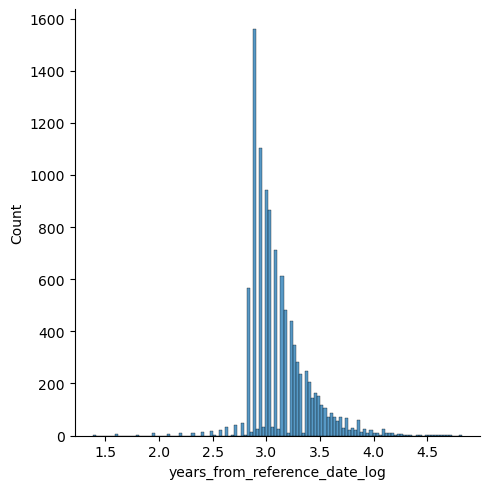

In [55]:
sns.displot(df_title_auth_num['years_from_reference_date_log'])

From univariate point of view, it is visible that the log transformation method resulted in better distribution

In [56]:
df_title_auth_num[['average_rating_log', 'ratings_count_log', 'num_pages_log', 'text_reviews_count_log',
                  'days_from_reference_date_log', 'months_from_reference_date_log',
                  'years_from_reference_date_log']].corr()

,average_rating_log,ratings_count_log,num_pages_log,text_reviews_count_log,days_from_reference_date_log,months_from_reference_date_log,years_from_reference_date_log
average_rating_log,1.000000,0.111717,0.063641,0.053376,0.048755,0.048659,0.050312
ratings_count_log,0.111717,1.000000,0.210563,0.957143,-0.119594,-0.119645,-0.118251
num_pages_log,0.063641,0.210563,1.000000,0.185752,0.011059,0.011105,0.011938
text_reviews_count_log,0.053376,0.957143,0.185752,1.000000,-0.148027,-0.148070,-0.146618
days_from_reference_date_log,0.048755,-0.119594,0.011059,-0.148027,1.000000,0.999987,0.998828
months_from_reference_date_log,0.048659,-0.119645,0.011105,-0.148070,0.999987,1.000000,0.998836
years_from_reference_date_log,0.050312,-0.118251,0.011938,-0.146618,0.998828,0.998836,1.000000


In [57]:
df_title_auth_num[['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count',
                   'days_from_reference_date', 'months_from_reference_date', 'years_from_reference_date']].corr()

,average_rating,num_pages,ratings_count,text_reviews_count,days_from_reference_date,months_from_reference_date,years_from_reference_date
average_rating,1.000000,0.165774,0.040421,0.030609,0.048209,0.048116,0.049476
num_pages,0.165774,1.000000,0.031158,0.032971,0.017001,0.017018,0.018338
ratings_count,0.040421,0.031158,1.000000,0.871895,-0.048778,-0.048791,-0.048813
text_reviews_count,0.030609,0.032971,0.871895,1.000000,-0.070760,-0.070761,-0.070892
days_from_reference_date,0.048209,0.017001,-0.048778,-0.070760,1.000000,0.999993,0.999388
months_from_reference_date,0.048116,0.017018,-0.048791,-0.070761,0.999993,1.000000,0.999391
years_from_reference_date,0.049476,0.018338,-0.048813,-0.070892,0.999388,0.999391,1.000000


From bivariate point of view, again, there are trade-off between correlations of the target and feature.

In [58]:
df_title_auth_num.columns

Index(['bookname_author1', 'language_code', 'num_pages', 'ratings_count',
       'text_reviews_count', 'average_rating', 'days_from_reference_date',
       'months_from_reference_date', 'years_from_reference_date',
       'ratings_count_log', 'num_pages_log', 'text_reviews_count_log',
       'average_rating_log', 'days_from_reference_date_log',
       'months_from_reference_date_log', 'years_from_reference_date_log'],
      dtype='object')

## Modelling

### Data Splitting

In [59]:
X = df_title_auth_num[['ratings_count', 'num_pages', 'text_reviews_count', 'language_code',
                       'days_from_reference_date', 'months_from_reference_date', 'years_from_reference_date']]
y = df_title_auth_num['average_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

In [60]:
X_log = df_title_auth_num[['ratings_count_log', 'num_pages_log', 'text_reviews_count_log', 'language_code',
                          'days_from_reference_date_log', 'months_from_reference_date_log', 'years_from_reference_date_log']]
y_log = df_title_auth_num['average_rating_log']

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size = 0.2, random_state=1)

In [61]:
X_train

,ratings_count,num_pages,text_reviews_count,language_code,days_from_reference_date,months_from_reference_date,years_from_reference_date
6048,22721.0,216.0,1111.0,eng,6604.0,216.0,18.0
871,22255.0,233.0,710.0,eng,8980.0,295.0,24.0
2517,2356.0,112.0,103.0,eng,6941.0,228.0,19.0
3071,4687.0,98.0,19.0,eng,7093.0,233.0,19.0
2106,393.0,176.0,57.0,eng,17135.0,562.0,46.0
...,...,...,...,...,...,...,...
2895,12754.0,80.0,558.0,eng,8228.0,270.0,22.0
7813,11.0,240.0,4.0,eng,7761.0,254.0,21.0
905,293.0,204.0,31.0,spa,6484.0,213.0,17.0
5192,36.0,741.0,2.0,glg,6369.0,209.0,17.0


In [62]:
X_train_log

,ratings_count_log,num_pages_log,text_reviews_count_log,language_code,days_from_reference_date_log,months_from_reference_date_log,years_from_reference_date_log
6048,10.031089,5.379897,7.013915,eng,8.795582,5.379897,2.944439
871,10.010367,5.455321,6.566672,eng,9.102867,5.690359,3.218876
2517,7.765145,4.727388,4.644391,eng,8.845345,5.433722,2.995732
3071,8.452761,4.595120,2.995732,eng,8.867005,5.455321,2.995732
2106,5.976351,5.176150,4.060443,eng,9.748937,6.333280,3.850148
...,...,...,...,...,...,...,...
2895,9.453679,4.394449,6.326149,eng,9.015420,5.602119,3.135494
7813,2.484907,5.484797,1.609438,eng,8.956995,5.541264,3.091042
905,5.683580,5.323010,3.465736,spa,8.777247,5.365976,2.890372
5192,3.610918,6.609349,1.098612,glg,8.759355,5.347108,2.890372


### Experimenting with The Model

We have looked at the behaviour of the data by performing some statistical analysis methods. From the result of the analysis, it is necessary to run an experiment to answer several questions:
* What is the best model in our case?
* Does log transformation really give significant impact to the model's performance?
* We defined several features that indicate strong collinearity such as `text_reviews_count` vs `ratings_count` and `days_from_reference_date` vs `months_from_reference_date` vs `years_from_reference_date`. Does removal one or more of these features make the model perform better?

To run such experiment, it would be the best practice to put the pre-processing component inside a pipeline to eliminate the possibility of data leak (the distribution of the training data affect the distribution of testing data) which can lead to biased result.

Here is the brief explanation of the preprocessing pipeline:
* `BinaryEncoder()` will be applied to the `language_code` feature. This method perform quite similar to the `OneHotEncoder()` but it will take lesser dimension in the feature space since it will convert the class into binary bitstrings (e.g. 0001, 0010, 0011, ...).
* `StandardScaler()` will be applied to the numerical features such as `ratings_count`, `num_pages`, `text_reviews_count`, `days_from_reference_date`, `months_from_reference_date`, `years_from_reference_date` for standardizing features by removing the mean and scaling to unit variance.
* `PolynomialFeatures()` will be applied to the numerical feature to expand the possibility of finding good predictor to the target. Here, arguments `degree=2` and `interaction_only=True` used to limit the polynomial combination up to the second degree and to exclude the combination of the same feature (e.g. `x^2`, `y^2` excluded, only `x*y` included)

The modeling experiment will be performed iteratively by using 6 kinds of feature sets:
* All of the untransformed numerical features including the `language_code` : 
`['ratings_count', 'num_pages', 'text_reviews_count', 'days_from_reference_date', 'months_from_reference_date', 'years_from_reference_date', 'language_code']`
* Same like number 1 but without `text_reviews_count`
* Same like number 1 but without `days_from_reference_date` and `months_from_reference_date`
* Same like number 1 but without `text_reviews_count`, `days_from_reference_date` and `months_from_reference_date`
* All of the log-transformed numerical features including the `language_code` : 
`['ratings_count_log', 'num_pages_log', 'text_reviews_count_log', 'days_from_reference_date_log', 'months_from_reference_date_log', 'years_from_reference_date_log', 'language_code']`
* Same like number 3 but without `text_reviews_count_log`
* Same like number 3 but without `days_from_reference_date_log` and `months_from_reference_date_log`
* Same like number 3 but without `text_reviews_count_log`, `days_from_reference_date_log` and `months_from_reference_date_log`

Models used:
* `LinearRegression()` with argument `n_jobs=-1` to enable parallel computation
* `SVR()` with argument `kernel='rbf'`
* `RandomForestRegressor()` with arguments `random_state=2023` and `n_jobs=-1` to set the random seed and to enable parallel computation
* `GradientBoostingRegressor()` with argument `random_state=2023` to enable parallel computation

The experiment will be run 5 times for each combination of the preprocessing and data feature sets. The mean and standard deviation of r-squared and RMSE will be calculated in order to define the model's performance and stability in every iteration.

In [63]:
def try_models(model='lr', transformation='none', features='all'):
    binary_enc = ce.BinaryEncoder()
    scaler = StandardScaler()
    poly = PolynomialFeatures(degree=2, interaction_only=True)

    lr = LinearRegression(n_jobs=-1) 
    svr_rbf = SVR(kernel = 'rbf')
    rf = RandomForestRegressor(random_state=2023, n_jobs=-1)
    gbr = GradientBoostingRegressor(random_state=2023)
    
    cols = ['ratings_count', 'num_pages', 'text_reviews_count',
            'days_from_reference_date', 'months_from_reference_date', 
            'years_from_reference_date']
    
    cols_log = ['ratings_count_log', 'num_pages_log', 'text_reviews_count_log',
            'days_from_reference_date_log', 'months_from_reference_date_log', 
            'years_from_reference_date_log']
    
    if features == 'all' and transformation == 'none':
        cols = cols
    elif features == 'a_removed' and transformation == 'none':
        cols.remove('text_reviews_count')
    elif features == 'b_removed' and transformation == 'none':
        cols.remove('days_from_reference_date')
        cols.remove('months_from_reference_date')
    elif features == 'ab_removed' and transformation == 'none':
        cols.remove('text_reviews_count')
        cols.remove('days_from_reference_date')
        cols.remove('months_from_reference_date')
    elif features == 'all' and transformation == 'log':
        cols_log = cols_log
    elif features == 'a_removed' and transformation == 'log':
        cols_log.remove('text_reviews_count_log')
    elif features == 'b_removed' and transformation == 'log':
        cols_log.remove('days_from_reference_date_log')
        cols_log.remove('months_from_reference_date_log')
    elif features == 'ab_removed' and transformation == 'log':
        cols_log.remove('text_reviews_count_log')
        cols_log.remove('days_from_reference_date_log')
        cols_log.remove('months_from_reference_date_log')

    num_pipe = Pipeline([
        ('poly', poly),
        ('scaler', scaler)
    ])
    
    cat_pipe = Pipeline([
        ('binary', binary_enc)
    ])
    
    if transformation == 'none':
        transformer = ColumnTransformer([
            ('categorical_prep', binary_enc, ['language_code']),
            ('numerical_prep', num_pipe, cols)
        ], remainder='drop')
    elif transformation == 'log':
        transformer = ColumnTransformer([
            ('categorical_prep', binary_enc, ['language_code']),
            ('numerical_prep', num_pipe, cols_log)
        ], remainder='drop')


    if model == 'lr':
        reg = lr
    elif model == 'svr_rbf':
        reg = svr_rbf
    elif model == 'rf':
        reg = rf
    elif model == 'gbr':
        reg = gbr

    estimator = Pipeline([
        ('preprocess', transformer),
        ('reg', reg)
    ])
    
    if transformation == 'none':
        model_cv = cross_validate(estimator, X_train, y_train, cv=5, 
                                  scoring=('r2','neg_root_mean_squared_error'))
    elif transformation == 'log':
        model_cv = cross_validate(estimator, X_train_log, y_train_log, cv=5, 
                          scoring=('r2','neg_root_mean_squared_error'))

    return estimator, pd.DataFrame(model_cv)

In [64]:
estimator, df = try_models('lr', 'none', 'all')

In [65]:
df

,fit_time,score_time,test_r2,test_neg_root_mean_squared_error
0,0.024291,0.004046,-0.045000,-0.310524
1,0.018473,0.004017,0.045331,-0.292860
2,0.017542,0.004160,0.053298,-0.283341
3,0.018453,0.003992,0.034421,-0.292497
4,0.017159,0.004007,0.036221,-0.294947


Now it's time to run the experiment

In [66]:
for m in ['lr', 'svr_rbf', 'rf', 'gbr']:
    for t in ['none', 'log']:
        for f in ['all', 'a_removed', 'b_removed', 'ab_removed']:
            _ , model_cv = try_models(model=m, transformation=t, features=f)

            print(f"Mean R-squared of {m} with {t} numerical transformation and {f} features : {round(model_cv.test_r2.mean(), 4)}")
            print(f"Mean RMSE of {m} with {t} numerical transformation {f} features: {round(model_cv.test_neg_root_mean_squared_error.mean(), 4)}")
            print(f"STD R-squared of {m} with {t} numerical transformation {f} features: {round(model_cv.test_r2.std(), 4)}")
            print(f"STD RMSE of {m} with {t} numerical transformation {f} features: {round(model_cv.test_neg_root_mean_squared_error.std(), 4)}")
            print("")

Mean R-squared of lr with none numerical transformation and all features : 0.0249
Mean RMSE of lr with none numerical transformation all features: -0.2948
STD R-squared of lr with none numerical transformation all features: 0.0398
STD RMSE of lr with none numerical transformation all features: 0.0098

Mean R-squared of lr with none numerical transformation and a_removed features : 0.0346
Mean RMSE of lr with none numerical transformation a_removed features: -0.2934
STD R-squared of lr with none numerical transformation a_removed features: 0.017
STD RMSE of lr with none numerical transformation a_removed features: 0.0068

Mean R-squared of lr with none numerical transformation and b_removed features : 0.0273
Mean RMSE of lr with none numerical transformation b_removed features: -0.2945
STD R-squared of lr with none numerical transformation b_removed features: 0.0301
STD RMSE of lr with none numerical transformation b_removed features: 0.0085

Mean R-squared of lr with none numerical tra

Mean R-squared of gbr with none numerical transformation and b_removed features : 0.0961
Mean RMSE of gbr with none numerical transformation b_removed features: -0.2839
STD R-squared of gbr with none numerical transformation b_removed features: 0.011
STD RMSE of gbr with none numerical transformation b_removed features: 0.0049

Mean R-squared of gbr with none numerical transformation and ab_removed features : 0.0631
Mean RMSE of gbr with none numerical transformation ab_removed features: -0.289
STD R-squared of gbr with none numerical transformation ab_removed features: 0.0171
STD RMSE of gbr with none numerical transformation ab_removed features: 0.005

Mean R-squared of gbr with log numerical transformation and all features : 0.088
Mean RMSE of gbr with log numerical transformation all features: -0.0598
STD R-squared of gbr with log numerical transformation all features: 0.0095
STD RMSE of gbr with log numerical transformation all features: 0.0024

Mean R-squared of gbr with log nume

From this modeling stage we see that `Gradient Boosting Regressor` model give the best result to predict the target from the features we defined. Log transformation method does not give significant improvement to the model's performance (even worse). Therefore, we can say that such transformation method is redundant to be included in our  ML pipeline. This happend because GBR is not a linear model therefore fixing the data distribution will not help much. Moreover, by skipping the log transformation, the interpretation stage would be more easier since we do not have to re-convert the result back to the real value.

From the features side, collinearity removal in the features extracted from the `publication_date` resulting the best performance in this experiment. So we will use these features to train the model.
* `ratings_count`
* `num_pages`
* `text_reviews_count` 
* `years_from_reference_date`
* `language_code`

### Hyperparameters Tunning

As a variant of gradient boosting models, `GradientBoostingRegressor()` model has wide range of possibility of modification. So in this stage we can do hyperparameter tunning to find the best hyperparameter values for our model. In this step, we will use the `GridSearchCV()` with 5-fold cross-validation method to run the experiment.

The hyperparameters used are:
* `n_estimators`
* `learning_rate`
* `max_depth`
* `min_samples_leaf`
* `max_features`

`GridSearchCV()` will fit perform the training with all possible combination of the pre-defined hyperparameters, so the process might take sometimes to finish.

In [67]:
def ml_pipeline():
    binary_enc = ce.BinaryEncoder()
    scaler = StandardScaler()
    poly = PolynomialFeatures(degree=2, interaction_only=True)

    gbr = GradientBoostingRegressor()

    num_pipe = Pipeline([
        ('poly', poly),
        ('scaler', scaler)
    ])
    
    cat_pipe = Pipeline([
        ('binary', binary_enc)
    ])
    
    transformer = ColumnTransformer([
        ('categorical_prep', binary_enc, ['language_code']),
        ('numerical_prep', num_pipe, ['ratings_count', 'num_pages', 'text_reviews_count', 'years_from_reference_date'])
    ], remainder='drop')

    estimator = Pipeline([
        ('preprocess', transformer),
        ('gbr', gbr)
    ])
    
    return estimator

In [68]:
def grid_search_best_model(params, k_fold, X_train, y_train):
    estimator = ml_pipeline()
    
    grid_search = GridSearchCV(estimator,
                               params,                             
                               cv=k_fold).fit(X_train,y_train)
    print("Best params", grid_search.best_params_)
    print("Best estimator", grid_search.best_estimator_)
    print("Best score:", grid_search.best_score_)
    
    return grid_search.best_estimator_

In [69]:
model_results = {}

def score_model(estimator, X_train, X_test, y_train, y_test,
               show_plot=True):   
    
    y_pred = estimator.predict(X_test)  
    print(f"Training score: {estimator.score(X_train,y_train)}")
    print(f"Test score: {r2_score(y_test, y_pred)}")
    print("MSE: ", mean_squared_error(y_test, y_pred))
    
    predictions_comparision = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).sample(25)
    if show_plot == True:
        predictions_comparision.plot(kind="bar", figsize=(12,8),title="Actual vs predicted values")
    print(predictions_comparision.sample(10))    
    
    
    return {
        "training_score": estimator.score(X_train,y_train),
        "test_score_r2" : r2_score(y_test, y_pred),
        "test_score_mse" : mean_squared_error(y_test, y_pred)
    }

In [70]:
k_fold = list(KFold(n_splits=5, shuffle=True).split(X_train, y_train))

params={"gbr__n_estimators":[20, 50, 100,200], 
        "gbr__learning_rate": [0.01, 0.05, 0.1, 0.3],
         "gbr__max_depth":[3,5,10], 
        "gbr__min_samples_leaf": [3,5],
          "gbr__max_features": [0.3, 1]
       }        

gbr = grid_search_best_model(params,k_fold, X_train, y_train)

Best params {'gbr__learning_rate': 0.01, 'gbr__max_depth': 10, 'gbr__max_features': 0.3, 'gbr__min_samples_leaf': 5, 'gbr__n_estimators': 200}
Best estimator Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_prep',
                                                  BinaryEncoder(),
                                                  ['language_code']),
                                                 ('numerical_prep',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(interaction_only=True)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['ratings_count', 'num_pages',
                                                   'text_reviews_count',
                               

Training score: 0.36128421615339024
Test score: 0.10863689717176783
MSE:  0.08384260452185714
      Actual  Predicted
1011    4.17   3.907840
920     4.30   3.820436
1335    4.38   4.092659
487     4.14   3.959218
1724    3.95   4.005011
1343    4.01   3.974488
763     3.65   3.929191
2083    4.08   3.994958
873     4.00   4.000971
265     3.77   3.905195


{'training_score': 0.36128421615339024,
 'test_score_r2': 0.10863689717176783,
 'test_score_mse': 0.08384260452185714}

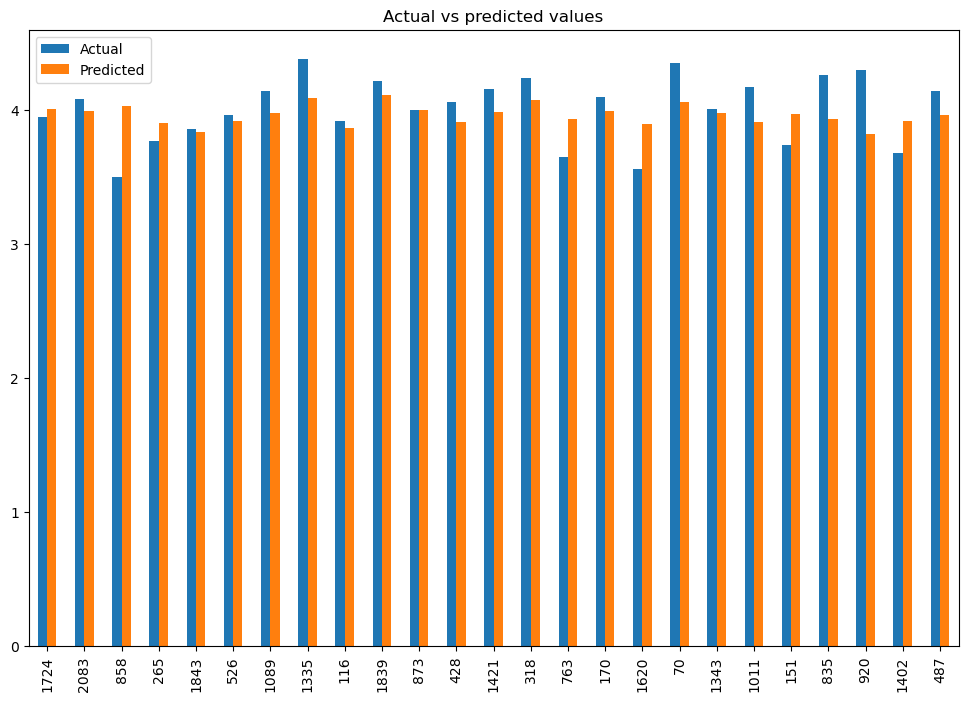

In [71]:
score_model(gbr, X_train, X_test, y_train, y_test)

From this step we found the best hyperparameters for our Gradient Boosting Regressor are:
```
    {
    'gbr__learning_rate': 0.01, 
    'gbr__max_depth': 10, 
    'gbr__max_features': 0.3, 
    'gbr__min_samples_leaf': 3, 
    'gbr__n_estimators': 200
    }
 ```

### Serialize The Best Model

Since the experiment took quite long time to finish, it would be needed to save the model into `.pkl` file so we can re-use the model for running the inference in the future.

In [72]:
gbr

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_prep',
                                                  BinaryEncoder(),
                                                  ['language_code']),
                                                 ('numerical_prep',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(interaction_only=True)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['ratings_count', 'num_pages',
                                                   'text_reviews_count',
                                                   'years_from_reference_date'])])),
                ('gbr',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=10,
                                           max_features=0.3, min_samples_leaf=5,
                                           n_estimators=200))])

In [73]:
model_dump_filename = "gbr_model_best_features.sav"
pickle.dump(gbr, open(model_dump_filename, 'wb'))
print("Successfully dumped the model to", model_dump_filename)

Successfully dumped the model to gbr_model_best_features.sav


## Result Analysis

Reload the model again to test the consistency of the serialization

In [74]:
gbr = pickle.load(open('gbr_model_best_features.sav', 'rb'))

In [75]:
gbr

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categorical_prep',
                                                  BinaryEncoder(),
                                                  ['language_code']),
                                                 ('numerical_prep',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(interaction_only=True)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['ratings_count', 'num_pages',
                                                   'text_reviews_count',
                                                   'years_from_reference_date'])])),
                ('gbr',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=10,
                                           max_features=0.3, min_samples_leaf=5,
                                           n_estimators=200))])

numerical_features = `[a, b, c]`
polynomial_features = `[ab, ac, bc]`

### Prediction Analysis

In [76]:
y_predicted = gbr.predict(X_test)

In [77]:
df_result = pd.DataFrame({
                    "y_test": y_test,
                    "y_predicted": y_predicted
                })

In [78]:
df_result.head(10)

,y_test,y_predicted
6184,3.99,3.895501
9179,3.96,4.020018
177,3.94,3.858009
5086,4.16,3.852089
8617,4.29,4.006055
7697,3.87,3.913696
891,4.44,3.866703
3583,4.27,4.053375
2065,4.05,3.962658
5252,3.46,3.976211


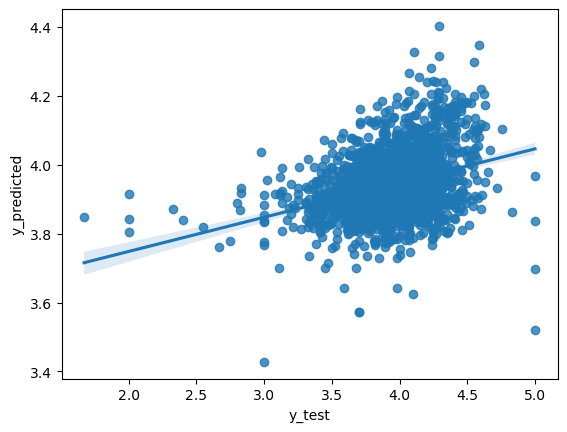

In [79]:
sns.regplot(data=df_result, x="y_test", y="y_predicted");

In [80]:
r2_score(y_test, y_predicted)

0.10863689717176783

### Model Interpretation

In [81]:
gbr['preprocess'].get_feature_names_out(), len(gbr['preprocess'].get_feature_names_out())

(array(['categorical_prep__language_code_0',
        'categorical_prep__language_code_1',
        'categorical_prep__language_code_2',
        'categorical_prep__language_code_3',
        'categorical_prep__language_code_4', 'numerical_prep__1',
        'numerical_prep__ratings_count', 'numerical_prep__num_pages',
        'numerical_prep__text_reviews_count',
        'numerical_prep__years_from_reference_date',
        'numerical_prep__ratings_count num_pages',
        'numerical_prep__ratings_count text_reviews_count',
        'numerical_prep__ratings_count years_from_reference_date',
        'numerical_prep__num_pages text_reviews_count',
        'numerical_prep__num_pages years_from_reference_date',
        'numerical_prep__text_reviews_count years_from_reference_date'],
       dtype=object),
 16)

In [82]:
gbr['gbr'].feature_importances_, len(gbr['gbr'].feature_importances_)

(array([0.        , 0.01037405, 0.01259746, 0.00262492, 0.00660748,
        0.        , 0.09405374, 0.15028516, 0.06745854, 0.06070273,
        0.10898553, 0.03834774, 0.11878119, 0.08984492, 0.15839307,
        0.08094348]),
 16)

In [83]:
X_train_preprocessed = gbr['preprocess'].transform(X_train)

In [84]:
perm = PermutationImportance(gbr['gbr'], random_state=2023).fit(X_train_preprocessed, y_train)
show_weights(perm, feature_names = gbr['preprocess'].get_feature_names_out().tolist())

Weight,Feature
0.1594 ± 0.0057,numerical_prep__ratings_count years_from_reference_date
0.1452 ± 0.0010,numerical_prep__ratings_count
0.1416 ± 0.0083,numerical_prep__num_pages
0.1258 ± 0.0072,numerical_prep__ratings_count num_pages
0.1218 ± 0.0036,numerical_prep__num_pages years_from_reference_date
0.1162 ± 0.0034,numerical_prep__num_pages text_reviews_count
0.0919 ± 0.0033,numerical_prep__text_reviews_count years_from_reference_date
0.0805 ± 0.0043,numerical_prep__text_reviews_count
0.0478 ± 0.0017,numerical_prep__years_from_reference_date
0.0326 ± 0.0006,numerical_prep__ratings_count text_reviews_count


In [85]:
X_test_preprocessed = gbr['preprocess'].transform(X_test)

In [86]:
perm_test = PermutationImportance(gbr['gbr'], random_state=2023).fit(X_test_preprocessed, y_test)
show_weights(perm_test, feature_names = gbr['preprocess'].get_feature_names_out().tolist())

Weight,Feature
0.0598 ± 0.0234,numerical_prep__ratings_count
0.0582 ± 0.0049,numerical_prep__ratings_count years_from_reference_date
0.0423 ± 0.0143,numerical_prep__num_pages
0.0334 ± 0.0082,numerical_prep__ratings_count num_pages
0.0307 ± 0.0132,numerical_prep__num_pages years_from_reference_date
0.0297 ± 0.0071,numerical_prep__num_pages text_reviews_count
0.0188 ± 0.0079,numerical_prep__text_reviews_count years_from_reference_date
0.0157 ± 0.0075,numerical_prep__text_reviews_count
0.0106 ± 0.0023,categorical_prep__language_code_2
0.0049 ± 0.0024,numerical_prep__years_from_reference_date


From the measurement of feature importance on training and testing data, a feature named `numerical_prep__ratings_count num_pages`score the highest importance. It shows the effectiveness of our polynomial feature engineering method that we have placed on the pipeline. 

In general, the most important features are:
* `numerical_prep__ratings_count num_pages`
* `numerical_prep__ratings_count`
* `numerical_prep__ratings_count years_from_reference_date`
* `numerical_prep__num_pages`

In [87]:
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=gbr['preprocess'].get_feature_names_out())

In [88]:
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=gbr['preprocess'].get_feature_names_out())

X_train_preprocessed_df = X_train_preprocessed_df[['numerical_prep__ratings_count num_pages',
                                                  'numerical_prep__ratings_count',
                                                  'numerical_prep__ratings_count years_from_reference_date',
                                                  'numerical_prep__num_pages']]

X_y_train_preprocessed_df = pd.concat([X_train_preprocessed_df, pd.Series(y_train).reset_index()['average_rating']], axis=1)

In [89]:
target_variable = 'average_rating'
correlations = X_y_train_preprocessed_df \
    .apply(lambda feature: pearsonr(feature, X_y_train_preprocessed_df[target_variable])[0] \
           if feature.name != target_variable else None)

In [90]:
correlations = correlations.drop(target_variable)

In [91]:
for feature, correlation in correlations.items():
    print(f'Correlation between {feature} and {target_variable}: {correlation:.4f}')

Correlation between numerical_prep__ratings_count num_pages and average_rating: 0.0535
Correlation between numerical_prep__ratings_count and average_rating: 0.0435
Correlation between numerical_prep__ratings_count years_from_reference_date and average_rating: 0.0468
Correlation between numerical_prep__num_pages and average_rating: 0.1615


For further analysis, pearson correlation coefficients of the fourmost important features are calculated. The numbers show positive relationship among all the features to the target variable.